OSE scentific computation final report  WS 2020/2021 Bonn University
Title
author: Po-Tse Cheng

In [1]:
import numpy as np 
import pandas as pd
import math
import time
import seaborn as sns
import matplotlib.pyplot as plt

from tools.auxiliary import*
from tools.Main_Results import*

This notebook contains the python implementation of the General Stochastic Simulation Algorithm (GSSA), developed by Kenneth L. Judde et. al (2011). 

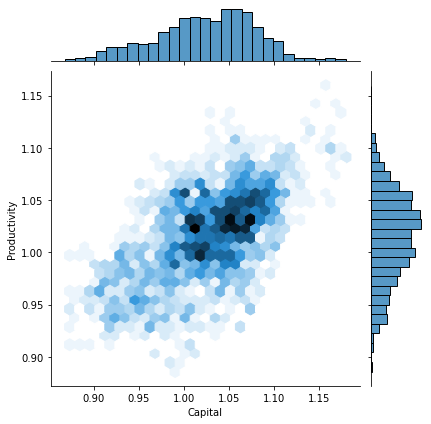

In [2]:
Figure1()

Original

In [3]:
df =reading("epsi10000.csv")
T  = 10000           #Choose the simulation length for the solution procedure, T<=10,000                    
gam     = 1        # Utility-function parameter
alpha   = 0.36     # Capital share in output
beta    = 0.99     # Discount factor
delta   = 0.02     # Depreciation rate 
rho     = 0.95     # Persistence of the log of the productivity level
sigma   = 0.01    # Standard deviation of shocks to the log of the productivity level
ks = ( (1-beta+beta*delta) / (alpha*beta) )**(1/(alpha-1) )
k = np.array([ks]*(T+1))
a= [1]*(T)
epsi = df.iloc[:,0].astype(float)*sigma
epsi=epsi.tolist()
for i in range(1, T):
    a[i]=a[i-1]**(rho)*math.exp(epsi[i])
a=np.asarray(a)
kdamp = 0.01    
dif_GSSA_1d = 1e+10  
bk_1d  = np.array([0., 0.95, ks*0.05])
bk_1d= np.reshape(bk_1d, (3,1))
k_old = [ks+1]*(T+1)

In [4]:
start = time.time()
y= GSSA_main_cycle(T, gam, alpha, beta, delta, kdamp, dif_GSSA_1d, a, bk_1d, k_old, k)
end = time.time()
elapsed_time = end-start

In [5]:
y = y.reshape((y.shape[0],1)) #make sure y is in the right shape
#The GSSA parameters

kdamp = 0.1
dif_GSSA_D = 1e+10

#The matrices of the polynomial coefficients
D_max  = 5 #because of python
npol = np.array([3, 6, 10, 15, 21])

# 13. Choose an integration method for computing solutions  
IM  = 10

n_nodes,epsi_nodes, weight_nodes= GH_Quadrature(Qn=10, N=1, vcv=sigma**2)

#make sure to change a into the right shape
a = np.reshape(a, (T, 1))
a1 = np.matmul(np.power(a,rho), np.exp(epsi_nodes.transpose()))

#14. Choose a regression specification 
RM = 6           # Choose a regression method: 
                 # 1=OLS,          2=LS-SVD,   3=LAD-PP,  4=LAD-DP, 
                 # 5=RLS-Tikhonov, 6=RLS-TSVD, 7=RLAD-PP, 8=RLAD-DP
normalize = 1    # Option of normalizing the data; 0=unnormalized data; 
                 # 1=normalized data                    
penalty = 7      # Degree of regularization for a regularization methods, 
                 # RM=5,6,7,8 (must be negative, e.g., -7 for RM=5,7,8 
                 # and must be positive, e.g., 7, for RM=6)
PF = 0           # Choose a polynomial family; 0=Ordinary (default);  
                 # 1=Hermite
# 15. Initialize the capital series
zb = np.matrix([[np.mean(k[0:T]), np.mean(a[0:T])], [np.std(k[0:T]), np.std(a[0:T])]])
z = np.concatenate((k[0:T].reshape(T,1), a[0:T].reshape(T,1)), axis=1)
k_old = [ks+1]*(T+1)

In [6]:
BK = []
Time = []
for d in range(1, D_max+1):
    start = time.time()
    BK.append(GSSA_poly(T, a, z, d, PF, zb, RM, penalty, normalize, dif_GSSA_D, kdamp, alpha, beta, delta, k, gam, y, k_old, a1, IM, n_nodes, weight_nodes, checker= 0))
    end = time.time()
    Time.append(end-start)

In [7]:
T_test = 10200

df =reading("epsi_test.csv")
epsi_test = sigma*df.to_numpy().astype(float)
a_test = [1]
for i in range(1,T_test):
    value = a_test[i-1]**(rho)*math.exp(float(epsi_test[i]))
    a_test.append(value)

IM_test = 10

k_test = [ks]
result_max = []
result_mean = []
result_time = []
for d in range(1, D_max+1):
    #refressing k_test to make sure that k_test is always 10200
    #k_test = [ks]
    for i in range(T_test):
        X_test = Ord_Herm_Pol_1(np.array([k_test[i], a_test[i]]).reshape([1,2]),d,PF,zb) # D = 1 for now, we will plug this in another for loop
        value = float(np.matmul(X_test, BK[d-1]))
        k_test.append(value)

        # testing it below
    discard = 200 #new defined value
    mean_error, max_error, error_time = Accuracy_Test_1(sigma,rho,beta,gam,alpha,delta,k_test,a_test,BK[d-1],d,IM_test,PF,zb,discard)
    result_max.append(max_error)
    result_mean.append(mean_error)
    result_time.append(error_time)

#after wrapping

In [3]:
Time, result_mean, result_max, result_time= GSSA_MainResult(D_Max=5, Rm=6, Norml=1, Pt=7, Pf=0 )

In [4]:

#construct df for ploting
showcase_result = pd.DataFrame(result_max, columns=["Maximum Error"])
showcase_result["Mean Error"] = result_mean
showcase_result["Time"] = Time
showcase_result["Error Time"] = result_time
showcase_result["Polynomial Degree"]= list(range(1,6))
showcase_result["Total Time"] = showcase_result["Error Time"] + showcase_result["Time"]
showcase_result["Rounded Total Time"]=showcase_result["Total Time"].round(decimals=2)
showcase_result["Original Mean Error"]= 10**(showcase_result["Mean Error"])
showcase_result["Original Max Error"]= 10**(showcase_result["Maximum Error"])
showcase_result.set_index(["Polynomial Degree"])

,Maximum Error,Mean Error,Time,Error Time,Total Time,Rounded Total Time,Original Mean Error,Original Max Error
Polynomial Degree,,,,,,,,
1,-3.366134,-4.358702,27.376122,0.709543,28.085665,28.09,4.378225e-05,4.303938e-04
2,-4.883611,-6.118154,47.962600,0.721990,48.684590,48.68,7.618090e-07,1.307343e-05
3,-5.951989,-7.481158,76.338214,0.974601,77.312814,77.31,3.302497e-08,1.116891e-06
4,-7.021109,-8.716908,101.023972,0.917214,101.941186,101.94,1.919073e-09,9.525560e-08
5,-8.071298,-9.920923,139.416764,1.020806,140.437571,140.44,1.199712e-10,8.485980e-09


<AxesSubplot:label='e0713b8a-8c0f-44c8-8f7a-91404a6504fb', xlabel='Rounded Total Time', ylabel='Mean Error'>

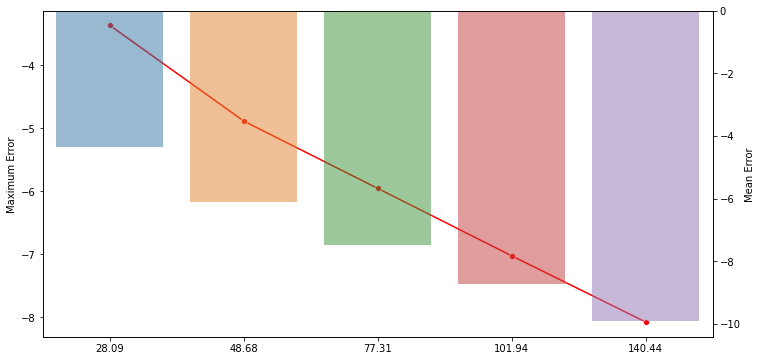

In [5]:
#plot with regards to time, maxi for visualisation
# add title and so on
ax1 = sns.set_style(style=None, rc=None )

fig, ax1 = plt.subplots(figsize=(12,6))

sns.lineplot(data = showcase_result["Maximum Error"], marker='o', ax=ax1, color='r')
ax2 = ax1.twinx()

sns.barplot(data = showcase_result, x="Rounded Total Time", y="Mean Error", alpha=0.5, ax=ax2)

In [6]:
df =reading("epsi10000.csv")
T  = 10000           #Choose the simulation length for the solution procedure, T<=10,000                    
gam     = 1        # Utility-function parameter
alpha   = 0.36     # Capital share in output
beta    = 0.99     # Discount factor
delta   = 0.02     # Depreciation rate 
rho     = 0.95     # Persistence of the log of the productivity level
sigma   = 0.01    # Standard deviation of shocks to the log of the productivity level
ks = ( (1-beta+beta*delta) / (alpha*beta) )**(1/(alpha-1) )
k = np.array([ks]*(T+1))
a= [1]*(T)
epsi = df.iloc[:,0].astype(float)*sigma
epsi=epsi.tolist()
for i in range(1, T):
    a[i]=a[i-1]**(rho)*math.exp(epsi[i])
a=np.asarray(a)
kdamp = 0.01    
dif_GSSA_1d = 1e+10  
bk_1d  = np.array([0., 0.95, ks*0.05])
bk_1d= np.reshape(bk_1d, (3,1))
k_old = [ks+1]*(T+1)
start = time.time()
y= GSSA_main_cycle(T, gam, alpha, beta, delta, kdamp, dif_GSSA_1d, a, bk_1d, k_old, k)
end = time.time()
elapsed_time = end-start
y = y.reshape((y.shape[0],1)) #make sure y is in the right shape
#The GSSA parameters

kdamp = 0.1
dif_GSSA_D = 1e+10

#The matrices of the polynomial coefficients
D_max  = 5 #because of python
npol = np.array([3, 6, 10, 15, 21])

# 13. Choose an integration method for computing solutions  
IM  = 10

n_nodes,epsi_nodes, weight_nodes= GH_Quadrature(Qn=10, N=1, vcv=sigma**2)

#make sure to change a into the right shape
a = np.reshape(a, (T, 1))
a1 = np.matmul(np.power(a,rho), np.exp(epsi_nodes.transpose()))

#14. Choose a regression specification 
RM = 5           # Choose a regression method: 
                 # 1=OLS,          2=LS-SVD,   3=LAD-PP,  4=LAD-DP, 
                 # 5=RLS-Tikhonov, 6=RLS-TSVD, 7=RLAD-PP, 8=RLAD-DP
normalize = 0    # Option of normalizing the data; 0=unnormalized data; 
                 # 1=normalized data                    
penalty = -7      # Degree of regularization for a regularization methods, 
                 # RM=5,6,7,8 (must be negative, e.g., -7 for RM=5,7,8 
                 # and must be positive, e.g., 7, for RM=6)
PF = 0           # Choose a polynomial family; 0=Ordinary (default);  
                 # 1=Hermite
# 15. Initialize the capital series
zb = np.matrix([[np.mean(k[0:T]), np.mean(a[0:T])], [np.std(k[0:T]), np.std(a[0:T])]])
z = np.concatenate((k[0:T].reshape(T,1), a[0:T].reshape(T,1)), axis=1)
k_old = [ks+1]*(T+1)
BK = []
Time = []



In [7]:
for d in range(1, D_max):
    start = time.time()
    BK.append(GSSA_poly(T, a, z, d, PF, zb, RM, penalty, normalize, dif_GSSA_D, kdamp, alpha, beta, delta, k, gam, y, k_old, a1, IM, n_nodes, weight_nodes))
    end = time.time()
    Time.append(end-start)

0.03519324152888481
0.00012850481462699654
0.00011964724575734838
0.00011145088069930203
0.00010385909042543511
9.682105478203465e-05
9.029105498703499e-05
8.422786383097872e-05
7.859421883928353e-05
7.335636611018834e-05
6.848366447504018e-05
6.394824122629742e-05
5.972469213020787e-05
5.578981928275715e-05
5.212240163934774e-05
4.870299369119998e-05
4.551374828820829e-05
4.253826058352317e-05
3.9761430007997194e-05
3.716933806725528e-05
3.474913983061015e-05
3.248896734567285e-05
3.0377843514048327e-05
2.8405604941253378e-05
2.6562832962208927e-05
2.484079150843741e-05
2.32313712165866e-05
2.172703897500657e-05
2.0320792286631198e-05
1.9006117860576185e-05
1.7776954018207732e-05
1.662765647248129e-05
1.5552967110957872e-05
1.4547985437176173e-05
1.3608142485324845e-05
1.2729176871494325e-05
1.1907112777786709e-05
1.1138239752987975e-05
1.0419094060748602e-05
9.746441507144303e-06
9.117261558781947e-06
8.528732686772609e-06
7.978218801215048e-06
7.463256620090548e-06
6.981544089699224

In [8]:
T_test = 10200

df =reading("epsi_test.csv")
epsi_test = sigma*df.to_numpy().astype(float)
a_test = [1]
for i in range(1,T_test):
    value = a_test[i-1]**(rho)*math.exp(float(epsi_test[i]))
    a_test.append(value)

IM_test = 10

k_test = [ks]
result_max = []
result_mean = []
result_time = []
for d in range(1, D_max):
    #refressing k_test to make sure that k_test is always 10200
    #k_test = [ks]
    for i in range(T_test):
        X_test = Ord_Herm_Pol_1(np.array([k_test[i], a_test[i]]).reshape([1,2]),d,PF,zb) # D = 1 for now, we will plug this in another for loop
        value = float(np.matmul(X_test, BK[d-1]))
        k_test.append(value)

        # testing it below
    discard = 200 #new defined value
    mean_error, max_error, error_time = Accuracy_Test_1(sigma,rho,beta,gam,alpha,delta,k_test,a_test,BK[d-1],d,IM_test,PF,zb,discard)
    result_max.append(max_error)
    result_mean.append(mean_error)
    result_time.append(error_time)



<AxesSubplot:label='ef8f5dc6-e402-4ee9-8730-39796ac67484', xlabel='Rounded Total Time', ylabel='Mean Error'>

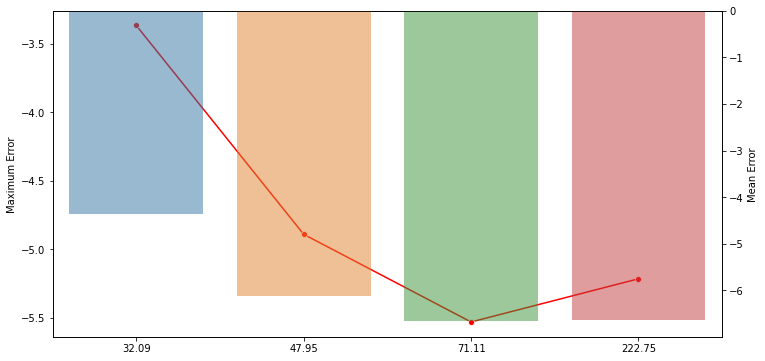

In [9]:
#construct df for ploting
#ols is not Stable with polynominal degree 5
showcase_result = pd.DataFrame(result_max, columns=["Maximum Error"])
showcase_result["Mean Error"] = result_mean
showcase_result["Time"] = Time
showcase_result["Error Time"] = result_time
showcase_result["Polynomial Degree"]= list(range(1,5))
showcase_result["Total Time"] = showcase_result["Error Time"] + showcase_result["Time"]
showcase_result["Rounded Total Time"]=showcase_result["Total Time"].round(decimals=2)
showcase_result["Original Mean Error"]= 10**(showcase_result["Mean Error"])
showcase_result["Original Max Error"]= 10**(showcase_result["Maximum Error"])
showcase_result.set_index(["Polynomial Degree"])
#plot with regards to time, maxi for visualisation
# add title and so on
ax1 = sns.set_style(style=None, rc=None )

fig, ax1 = plt.subplots(figsize=(12,6))

sns.lineplot(data = showcase_result["Maximum Error"], marker='o', ax=ax1, color='r')
ax2 = ax1.twinx()

sns.barplot(data = showcase_result, x="Rounded Total Time", y="Mean Error", alpha=0.5, ax=ax2)